In [1]:
!pip install tensorflow

In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import json
import os

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: []


In [4]:
# Dataset paths
testpath = r'/content/drive/MyDrive/modified-dataset/test'
trainpath = r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'

In [5]:
# Load datasets with (128,128) size - optimal for web deployment
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath, shuffle=True, image_size=(128, 128), batch_size=32, validation_split=False
)
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath, shuffle=False, image_size=(128, 128), batch_size=32, validation_split=False
)
datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath, shuffle=True, image_size=(128, 128), batch_size=32, validation_split=False
)

print(f"Number of classes: {len(datatrain.class_names)}")
class_names = datatrain.class_names
print(f"Classes: {class_names}")

Found 2430 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Number of classes: 10
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


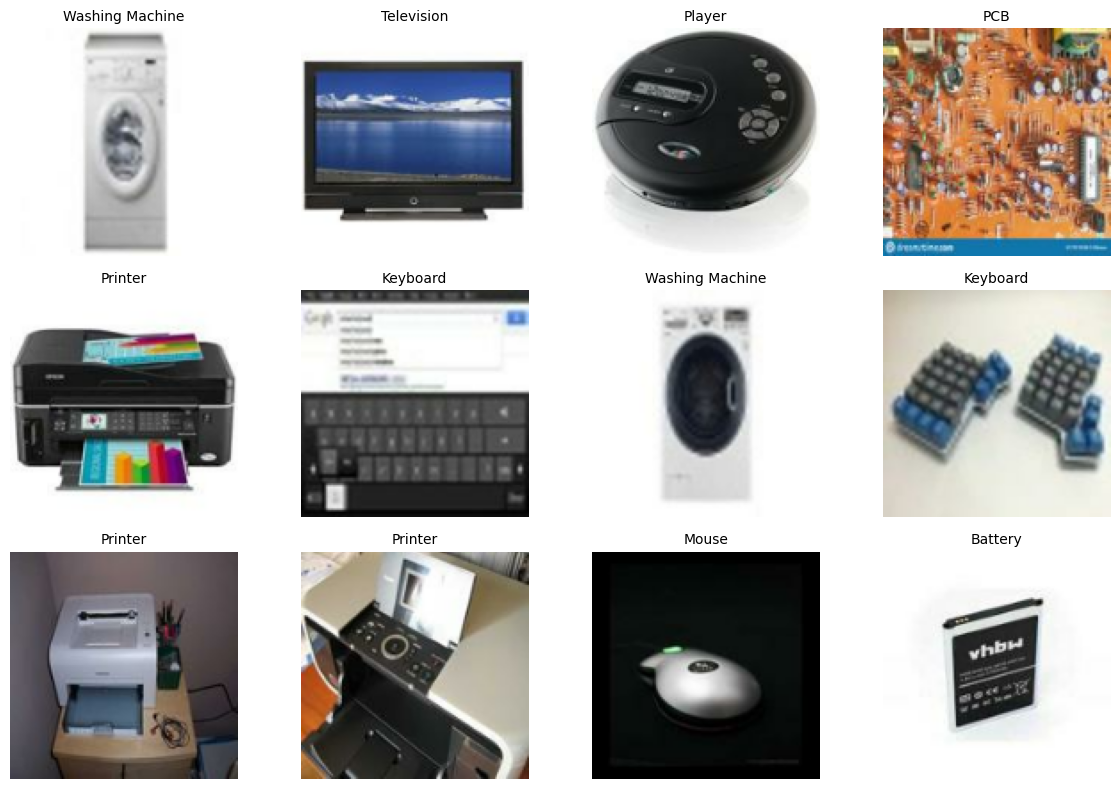

In [6]:
plt.figure(figsize=(12, 8))
for images, labels in datatrain.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

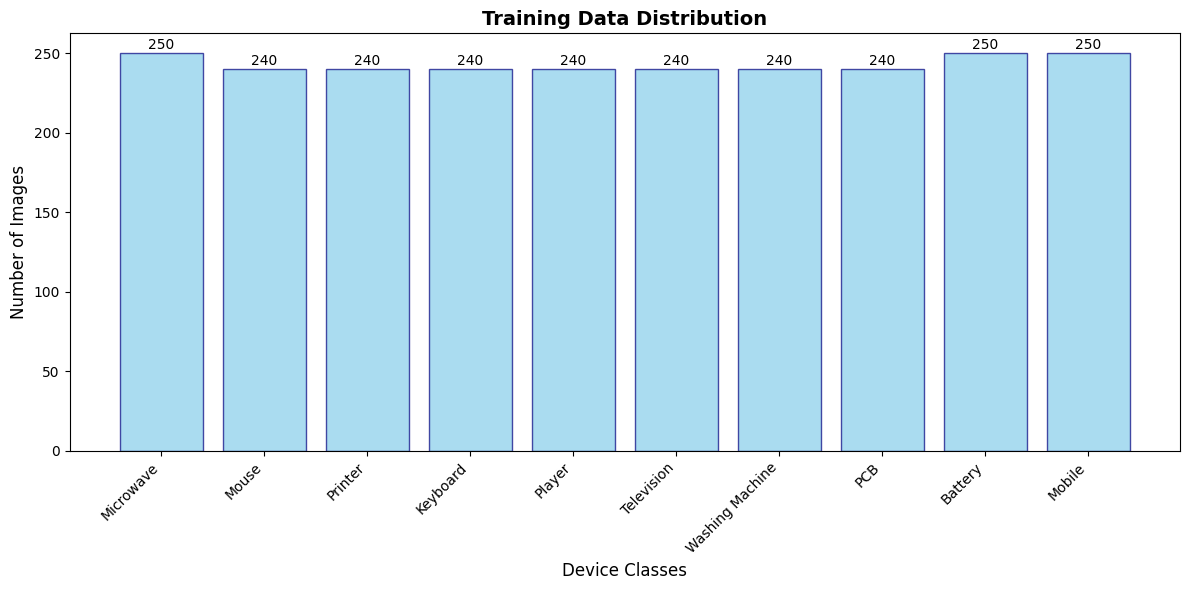

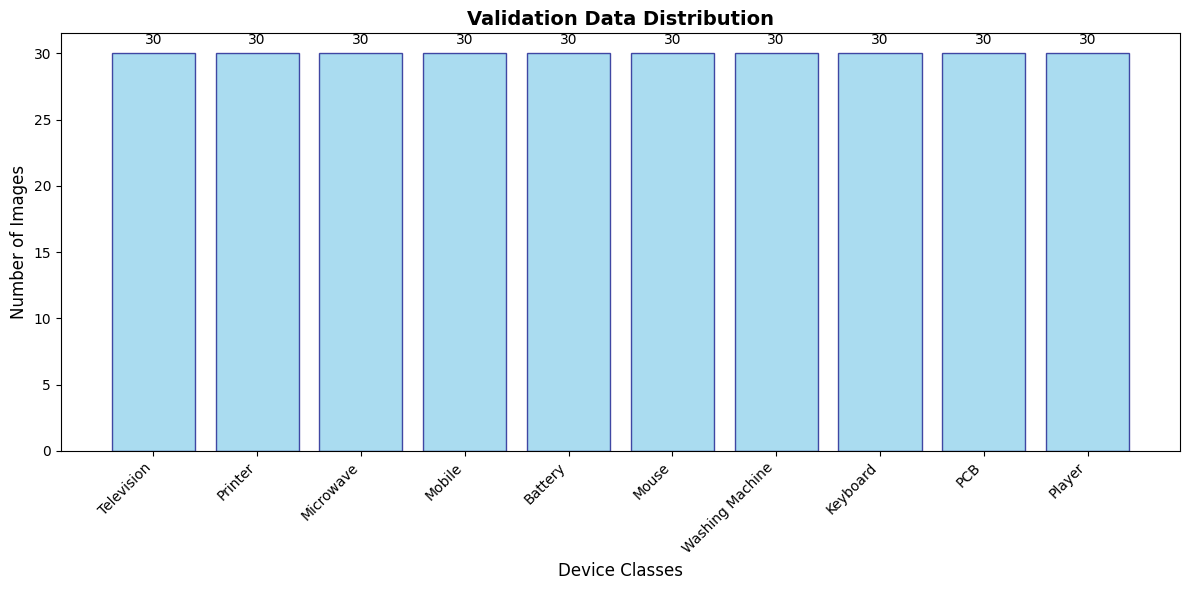

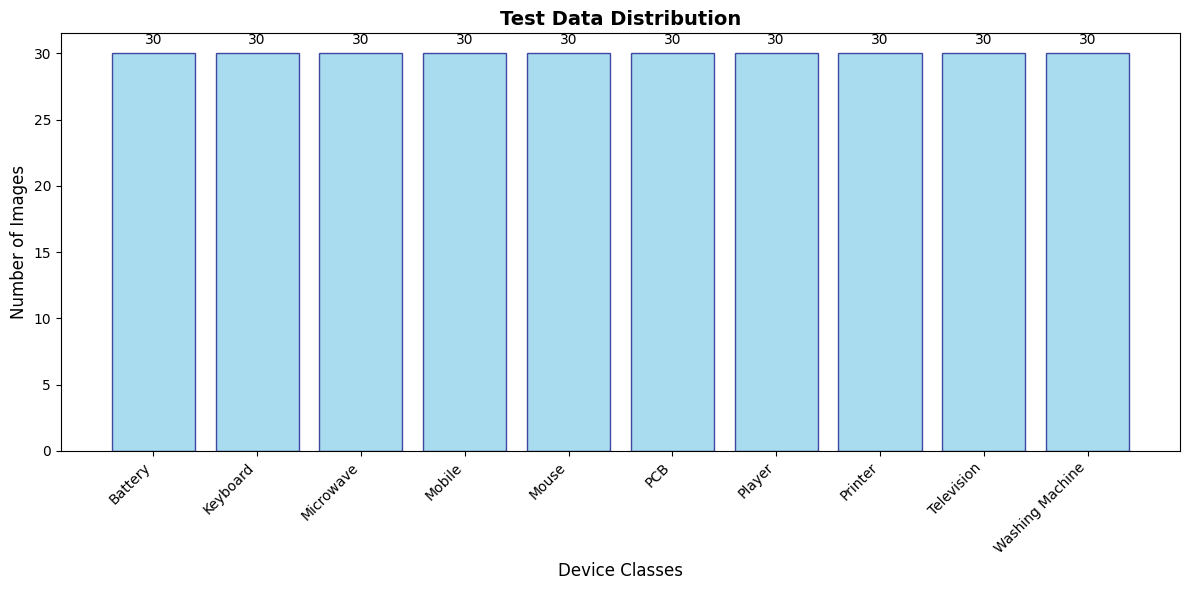

In [8]:
#Class Distribution Function
def plot_class_distribution(dataset, title="Class Distribution"):
    """Plot class distribution for better understanding of data balance"""
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]  # Use global class_names
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    class_names_list = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names_list, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel("Device Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [9]:
# Web-optimized data augmentation (lighter for faster training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),      # Reduced for web stability
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# ===== MobileNetV3Large - OPTIMIZED FOR WEB DEPLOYMENT =====
print("=== Building MobileNetV3Large for Web Application ===")

=== Building MobileNetV3Large for Web Application ===


In [15]:
# Load base model with optimal configuration for web deployment
base_model = MobileNetV3Large(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0,                    # Full model for best accuracy
    minimalistic=False,           # Use full model features
    include_preprocessing=False   # We'll handle preprocessing separately
)

# Strategic fine-tuning for web deployment
base_model.trainable = True

# Fine-tune only the last layers for faster convergence and better web performance
total_layers = len(base_model.layers)
freeze_until = total_layers - 30  # Unfreeze last 30 layers

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    # Keep BatchNormalization layers frozen for inference stability
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print(f"Total layers: {total_layers}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")
print(f"Frozen layers: {sum(1 for layer in base_model.layers if not layer.trainable)}")


Total layers: 186
Trainable layers: 24
Frozen layers: 162


In [16]:
# Build model optimized for web deployment
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3), name="input_layer"),
    data_augmentation,

    # Preprocessing layer for consistent input handling
    tf.keras.layers.Rescaling(1./127.5, offset=-1, name="rescaling"),

    base_model,

    # Efficient head for web deployment
    tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool"),
    tf.keras.layers.Dropout(0.3, name="dropout_1"),

    # Additional dense layer for better feature learning
    tf.keras.layers.Dense(128, activation='relu', name="dense_128"),
    tf.keras.layers.Dropout(0.2, name="dropout_2"),

    # Output layer
    tf.keras.layers.Dense(10, activation='softmax', name="predictions")
], name="MobileNetV3Large_WebOptimized")

In [17]:
# Check TensorFlow version and adjust optimizer accordingly
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [31]:
# Use Adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name="Adam"
)

In [32]:
# Compile with mixed precision compatible configuration
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "MobileNetV3Large_WebOptimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 4, 4, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,650 (11.90 MB)

 Trainable params: 1,710,698 (6.53 MB)

 Non-trainable params: 1,409,952 (5.38 MB)

In [28]:
# Custom callback for training monitoring
class WebTrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'learning_rate'):
            if hasattr(self.model.optimizer.learning_rate, 'numpy'):
                lr = self.model.optimizer.learning_rate.numpy()
            else:
                lr = self.model.optimizer.learning_rate
        else:
            lr = 0.001  # fallback
        print(f"Epoch {epoch + 1}: LR = {lr:.6f}, "
              f"Accuracy = {logs['accuracy']:.4f}, "
              f"Val Accuracy = {logs['val_accuracy']:.4f}")

In [33]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1,
    mode='max',
    min_delta=0.001
)

# Learning rate reduction
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5,
    min_lr=1e-7,
    verbose=1,
    cooldown=1
)

# Model checkpoint - Fixed to save as .keras format
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'mobilenetv3_large_web_model.keras',  # Changed to .keras format
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [35]:
# Cell 11: Training Configuration
epochs = 20
batch_size = 32

print("Starting optimized training for web deployment...")
print(f"Model parameters: {model.count_params():,}")

# Cell 12: Training
# Training with callbacks
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=[
        early_stopping,
        lr_reduction,
        checkpoint
    ],
    verbose=1
)

# The epoch got stoped because of the patience of 8 but i stopped it by 5 and the error it shows is just the same.

Starting optimized training for web deployment...
Model parameters: 3,120,650
Epoch 1/20


KeyboardInterrupt: 

In [38]:
model.summary()

Model: "MobileNetV3Large_WebOptimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 4, 4, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,542,052 (24.96 MB)

 Trainable params: 1,710,698 (6.53 MB)

 Non-trainable params: 1,409,952 (5.38 MB)

 Optimizer params: 3,421,402 (13.05 MB)

In [36]:
# Cell 13: Training History Visualization
def plot_training_history(history):
    """Training history plotting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

NameError: name 'history' is not defined

In [37]:
# Cell 15: Model Evaluation
print("=== Web Model Evaluation ===")
test_results = model.evaluate(datatest, verbose=1)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Top-2 Accuracy: {test_results[2]:.4f}")
print(f"Test Top-3 Accuracy: {test_results[3]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")

=== Web Model Evaluation ===
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9002 - loss: 0.4065
Test Accuracy: 0.9000


IndexError: list index out of range

In [ ]:
# Cell 16: Confusion Matrix and Classification Report
# Generate predictions for detailed analysis
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)
y_pred_probs = model.predict(datatest, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n=== Detailed Performance Analysis ===")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Cell 17: Confusion Matrix Visualization
# Enhanced confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            cbar_kws={'label': 'Number of Predictions'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - MobileNetV3Large Web Model', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()